# A bow shocks near GRS 1915+105

This notebook is partly based off the calculations presented in Gallo et al. 2004 to interpret the bow shock observed in the vicinity of Cyg X-1. Calculations have been adapted to the case of GRS 1915+105, near which we identified a bow shock similar to (albeit much larger than) that seen close to Cyg X-1. 
Additions have been made based on Kaiser et al. 2004 (who aready modelled a structure near GRS 1915+105 observed in radio), but did not see any large-scale bow shock due to the limited sensitivity of the VLA images they used.

In this version of the notebook we make the (reasonable) assumption that the hydrogen emitting the bow shock radiation is fully ionized for the densities we are dealing with. Based on Saha's equation, with densities of the order 0.1-1000 particles per unit volume all hydrogen should be ionized at a temperature of ~ 1000K. In order to have a ionization fraction different from 1, the density has to be at least 1E+06, which is way higher than the average ISM density.  
In this regard, our treatment differs from that followed by Gallo et al., who assumed a given ionization fraction. 
In the following we treat separately the three components of the jet-ISM interaction region near GRS 1915+105, following the formalism described in Kaiser et al. 2004. 


Based on Kaiser et al. 2004, the **emission connected with the jets from GRS 1915+105 is formed by three components:** **(i)** the **thermal Bremsstrahlung emission** corresponding to the blobbly brightest region near IRAS 19132. Note that now the flux density is a factor of 10 lower than in 1998 (6 vs 60 mJy); **(ii)** the **non-thermal, possibly syncrotron emission** form the "hot spot", i.e. an elongated feature north-west from the IRAS region; **(iii)** the **bow shock emission**, with an average flux density of 0.2 mJy,  which is assumed to also be non-thermal syncrotron emission with a putative spectral slope of -0.8. This last component was not seen in the old VLA data, but interestingly it was indeed predicted by Kaiser et al. 2004. 

In order to determine the properties of the jet, we will do as follows.

(1) We derive the density of the shocked material in IRAS 19132, assuming that the gas is fully ionised and that the radiation is Bremsstrahlung for a minimum temperature of T ~ 10$^4$K. We model the IRAS region as a solid sphere.

(2) We infer the pre-shock ISM density knowing that the it should be about a factor of 4 smaller than in the shocked region. 

(3) We estimate the jet advancing velocity assuming that it equals the velocity of the bow shock in the ISM. From here we can estimate the jet age. 

(4) Finally, we estimate the jet energy transport rate using the density derived above, and the lobe aspect ratio measured from the MeerKAT image. 

(5) Assuming the density derived by Tetarenko et al. 2018 we also estimate the energy transferred to the IRAS 19132 region implied by a different value of the ISM density. 


### Some units:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math 
import cmath

# Some Constats and Units

pc = 3.086E+18       # 1 pc, cm 
mh = 1.6735575E-24   # Hydrogen mass, g 
me = 9.1093837E-28   # Electron mass, g 
eV = 1.602176634E-12 # ElectronVolt, erg
Jy = 1.0E-23         # 1 Jansky (erg/s/cm2/Hz), cgs
kb = 1.380649E-16;   # K boltzman, cgs
h =  6.6261E-27;     # Plank constant, cgs 
c = 3.0e10           # Speed of light, cgs 
Na = 6.022E+23       # Avogadro's number
Z=1                  # Hydrogen atomic number
e = 4.8e-10          # Electric charge cm3/2 g1/2 s-1

# Observation-specific quantities

nu = 1.2839E+9;      # Observing frequency, in Hz (L-band, MeerKAT, slightly lower than for Cyg X-1, Westerbork)
bmaj = 6.6           # Beam major axis, arcsec
bmin = 6.6           # Beam minor axis, arcsec

# Source specific quantities

d10 = 0.86;          # distance in units of 10 kpc, GRS 1915+105 --- KNOWN   
incl = 60;           # Source inclination to line of sight, deg --- KNOWN (Reid et al. 2014)
incl_err = 5         # Error on inclination angle
o_a = 50             # Opening angle
o_a_err = 0          # Opening angle error
Flobe = 0.00015;     # Bow shock flux density, Jy/beam -- MEASURED
Firas = 0.057;       # IRAS source INTEGRATED flux density, Jy -- MEASURED 
                     
Fcyl = 0.0052;       # IRAS northern feature flux density, Jy -- MEASURED
DR = 60              # Ring thickness, arcsec (on average) -- MEASURED
DR_err = 0.3
DRcm = (DR)*(0.048*d10*pc) # Ring thickness, in cm (on average)
Riras = 36           # IRAS source angular size (diameter), arcsec -- MEASURED 
Rirascm = Riras*0.048*d10*pc # IRAS source size (diameter), cm

theam = 12;                                   # Lobe angular size (diameter) in arcmin (projected) GRS 1915 --- MEASURED

lobesizepc = (theam*60)*0.048*d10             # Lobe radius in pc GRS 1915+105 --- MEASURED
lobesizecm = lobesizepc*pc                    # Lobe radius in cm GRS 1915+105

disamin = 17;                                 # Lobe-source angular distance in arcmin (projected) GRS 1915+105 --- MEASURED
disamin_err = 0.2
dispc = (disamin*60)*0.048*d10;               # source-ring separation (projected), in pc (= Lj, pc)
discmP = dispc*pc;                            # source-ring separation, (projected) in cm
discm = dispc*pc/math.sin(incl*math.pi/180);  # source-ring separation, DE-PROJECTED in cm (= Lj, cm)

print('Lobe size [pc] (lobesizepc) =', '{:.3e}'.format(lobesizepc)) #Lj
print('Source-ring separation (projected) [cm] (discmP) ~','{:.3e}'.format(discmP))
print('Source-ring separation (de-projected) [cm] (discm = Lj)~','{:.3e}'.format(discm))
print('Source-ring separation (de-projected) [pc] (dispc) ~','{:.3e}'.format(dispc))


# Assumptions
x = 1;               # Ionization fraction at T ~ 10^4
Tmin = 1.2E+4;                                # Lower-limit to post-shock temperature -- ASSUMED 
                                              # (from arguments based on Bremsstrahlung nature of the emission)
                                              # Also see Saha's equation below
        
# Pseudo-constants

# Gaunt factor
def gaunt(nu, T, z):
    F1 = 128.*(1**2)*(kb**3)*(T**3)
    F2 = me * (e**4)*(nu**2)*(z**2)    
    G = (3**0.5 / (2.*math.pi)) * (np.log(F1/F2) - 0.5772156649**2)    
    return G

g = gaunt(nu, Tmin, Z)

Lobe size [pc] (lobesizepc) = 2.972e+01
Source-ring separation (projected) [cm] (discmP) ~ 1.299e+20
Source-ring separation (de-projected) [cm] (discm = Lj)~ 1.500e+20
Source-ring separation (de-projected) [pc] (dispc) ~ 4.211e+01


### Large scale structure of the jet

#### 1)  IRAS 19132 - Bremsstrahlung

The emission from IRAS 19132 is characterised by a flat radio spectrum, which suggests a bremsstrahlung origin from a gas emitting at a temperature of T $\sim 10^4K$. This is supported by the detection of a H92$\alpha$ recombination line with width 25 km/s (Rodriguez & Mirabel 1998), which suggests a temperature of at least T $\sim$1.2$\times$ 10$^4K$.



The **monochromatic emissitivty $\epsilon_\nu$ of ionised hydrogen due to thermal bremsstrahlung** is given by (Longair 1994). 

 $$\epsilon_\nu = \frac{L_\nu}{V} = C_{radio} g(\nu, T) \frac{n_e^2}{\sqrt{T}} \exp{(\frac{h\nu}{k_b T})} ~~ erg~s^{-1}~cm^{-3}~Hz^{-1}$$

where 

$$ C_{radio} = 6.8\times 10^{-38} erg~s^{-1}~cm^{-3}~Hz^{-1} $$

Note that in Kaiser+2004 the constant is ~$10^{50}$ because the number densities are expressed in particles per meter cube: $(m^3)^2 = 10^{12} (cm^3)^2$.

The above assumes that **the number of electrons $n_e$ equals the number of protons n** (pure hydrogen gas), and that the density and temperature are uniform withing the considered volume. $\epsilon_\nu$ is the expression of the bremsstrahlung emissivity for a pure hydrogen gas emitting at a temperature T, and $V$ is the source unit volume. Since we have no information regarding the extent of the emission regions along our line of
sight or their exact three-dimensional geometrical structure, **we assume a spherical shape with diameter 36 arcsec, multiplied by a filling factor f$\sim$1**. 

From the Bremsstrahlung emissivity we can derive the electron density. 

$$n_e = \sqrt\frac{\epsilon_\nu}{g(\nu, T) \sqrt{T} C_{radio}}$$

where the Gaunt factor g($\nu$) is given by 

$$g(\nu, T) \approx \frac{\sqrt{3}}{2 \pi}\left[\ln \left(\frac{128 \epsilon_0^2 k^3 T^3}{m_e e^4 \nu^2 Z^2}\right)-\gamma^2\right]$$

As stated above, since we assume that the hydrogen in the region is fully ionized, the electron number density also corresponds to the total particle number density (under the assumption that the ISM is almost all hydrogen). 
**The electron density _in the shock_ is about 160 particles per cm$^3$**, and thus, assuming that the shock is approximately 4 times denser than the sourrounding medium, **the unshocked ISM electron density is about 40 particles per cm$^3$**. This is consistent with the typical density of an HII region, a factor ~10 or larger than the typical ISM density (1/cm$^3$). Since the bow shock seems to be connected with an HII region (CHIMPS 4894, based on SIMBAD, see http://simbad.cds.unistra.fr/simbad/sim-id?Ident=CHIMPS+4894&), the density we find seems appropriate. 

In [2]:
# Section 1: Calculating the gas density downstream with respect to the shock front, assuming 
# bremsstralung emission

Liras14 = Firas*Jy*(4*math.pi*(d10*10*1000*pc)**2); # Monochormatic ring luminosity in erg/sec/Hz 
                                                    # (d10 needs to be multiplied by 10!)
    
fill = 1                                            # Volume filling factor (solid sphere)
Vol = fill*4/3*math.pi*(Rirascm/2)**3;              # Volume = 4/3 pi (D/2)^3, with D = diameter

C_radio = 6.8*1e-38
nemin = math.sqrt( (Liras14/Vol*(math.sqrt(Tmin)))/(C_radio*g*math.exp(h*nu/(kb*Tmin ))) )  
                                                # Electron density from Bremmsstralung emissivity 
                                                # for a pure hydrogen gas emitting at T

ntmin = nemin/x;                                # Total particle density, which equals the electron 
                                                # density divided by ionization fraction, which in 
                                                # this case is 1 (for fully ionized hydrogen)
rhomin = ntmin*1.370*mh                         # Density of the gas post-shock, i.e. down-stream of 
                                                # the shock, g/cm3
rho0min = rhomin/4;                             # Density of the pre-shock gas, i.e. up-stream of the 
                                                # shock, g/cm3
   

print('Ring thickness [cm] (DRcm) =','{:.3e}'.format(DRcm))
print('IRAS volume [cm] (Vol) =', '{:.3e}'.format(Vol))

print('IRAS monochromatic Luminosity [erg/s/Hz] (Liras14) =', '{:.3e}'.format(Liras14))
print('Particle number density of shocked gas [1/cm3] (ntmin = ne/x) =','{:.3e}'.format(ntmin))
print('Particle number density of un-shocked gas [1/cm3] (nt0min = ntmin/4) =','{:.3e}'.format(ntmin/4))
print('Density of shocked gas [g/cm3] (rhomin) =','{:.3e}'.format(rhomin))
print('Density of un-shocked gas [g/cm3] rho0min =','{:.3e}'.format(rho0min))


R = Na*kb # gas constant
# Cross check the pressure of gas in ideal conditions. 
# pressure of gas inside IRAS source assuming ideal conditions
pideal = ntmin*kb*Tmin
print('Pressure inside IRAS (ideal gas conditions) [erg/cm3] (Pideal) = ', '{:.3e}'.format(pideal))

# pressure of gas of unshocked material assuming ideal conditions, and T = 50K
pidealunsh = ntmin*kb*50
print('Pressure in the ISM (ideal gas conditions) [erg/cm3] (pidealunsh) =', '{:.3e}'.format(pidealunsh))


Ring thickness [cm] (DRcm) = 7.643e+18
IRAS volume [cm] (Vol) = 5.050e+55
IRAS monochromatic Luminosity [erg/s/Hz] (Liras14) = 5.045e+21
Particle number density of shocked gas [1/cm3] (ntmin = ne/x) = 1.412e+02
Particle number density of un-shocked gas [1/cm3] (nt0min = ntmin/4) = 3.530e+01
Density of shocked gas [g/cm3] (rhomin) = 3.237e-22
Density of un-shocked gas [g/cm3] rho0min = 8.093e-23
Pressure inside IRAS (ideal gas conditions) [erg/cm3] (Pideal) =  2.339e-10
Pressure in the ISM (ideal gas conditions) [erg/cm3] (pidealunsh) = 9.747e-13


#### 2) Northern feature in IRAS 19132 - Synchrotron emission from gas

The radio maps of IRAS 19132+1035 show an elongated feature pointing in the direction of GRS 1915+105, with lengths of 17.4 arcsec, and width of 7.9 arcsec, and with a steep radio spectrum, located to the northwest of the main flat spectrum region. In the old VLA images this spectrum is consistent with a power law F $\propto$ $\nu^\alpha$ with $\alpha$ = -0.8.  This spectral index is typical for synchrotron emission and hence it implies the presence of a relativistic plasma consisting of magnetic field and a population of relativistic electrons. 

We will assume that we observe (or can infer, assume) a radio spectrum with some spectral index $\alpha$ between upper and lower frequencies $\nu_1, \nu_2$. We will need the integrated radio luminosity between these limits, and not just the specific radio luminosity at a certain frequency.

$$L=4 \pi D^2 \int_{\nu_1}^{\nu_2} F_{\nu} d\nu = 4 \pi D^2 F_{\nu_2} \nu_2^{-\alpha} \left( \frac{\nu_2^{\alpha+1} - \nu_1^{\alpha+1}}{\alpha+1} \right) $$

(an equivalent formula can of course be constructed using $\nu_1$ as the reference frequency). 
Here we use $\alpha = (1-p)/2$.**

Note, in comparing the analysis here with the simplified (but relatively accurate) formlua of Longair et al. 1994, that the $L_{\nu}$ used in that formula is the 'specific' luminosity in units erg s$^{-1}$ Hz$^{-1}$ whereas the *integrated* luminosity used here and defined above is in erg s$^{-1}$, and is therefore a larger quantity).

The energy density in magnetic fields is $B^2 / 8\pi$ (in cgs units), therefore for a volume $V$ the total energy in B fields is:

$$E_B = \frac{B^2}{8 \pi} f V $$

where $f$ is a *filling factor* which represents the fraction of the physical source's volume which is actually occupied by the magnetic field and relativistic particles.

Given a population of electrons with a power law distribution $-p$ between energy limits $E_1$ and $E_2$, the total energy in these electrons is given by:

$$E_e = c_2^{-1} L B^{-2} \frac{(p-3)}{(p-2)} \frac{(E_1^{2-p}-E_2^{2-p})}{(E_1^{3-p}-E_2^{3-p})}$$

For a given electron energy and magnetic field, we can characterise the synchrotron emission as coming from a single frequency $\nu = c_1 B E^2$, i.e. $E = \nu^{1/2} c_1^{-1/2} B^{-1/2}$. So, we can write:

$$E_e = c_2^{-1} c_1^{1/2} \tilde{c}(p, \nu_1, \nu_2) B^{-3/2} L = c_{12}(p,\nu_1,\nu_2) B^{-3/2} L$$

where

$$c_{12} = c_2^{-1} c_1^{1/2} \tilde{c}(p, \nu_1, \nu_2)$$

and

$$\tilde{c}(p, \nu_1, \nu_2) = \frac{(p-3)}{(p-2)} \frac{\nu_1^{(2-p)/2}-\nu_2^{(2-p)/2}}{\nu_1^{(3-p)/2}-\nu_2^{(3-p)/2}}$$

The pseudo-constant $c_{12}$ encapsulates all the information about the observed (or interpolated, extrapolated, assumed) frequency range of the observations and the slope of the energy spectrum between those limits. 

Since $E_B \propto B^2$, the total energy is given by

$$E_{e+B} = E_e + E_B =  const. B^{-3/2} + const. B^2$$

and therefore *there must be a minimum of the total energy as a function of $B$* (assuming there are no other contributions to the energy budget which have a different dependence on $B$). This minimum occurs at *equipartition* of the energy, when $E_e$ and $E_B$ are almost equal (differentiate $E_{e+B}$ with respect to $B$):

$$E_B = \frac34 \eta E_e$$

where $\eta$ indicates how much energy is stored in the protons which accompany the electrons (in the case of a normal baryonic plasma); $\eta = 1$ is generally considered for the minimum energy condition.
Substituting the above qxpressions, the equipartition magnetic field is given by:

$$B_{eq} = (6 \pi \frac{\eta}{f} c_{12} \frac{L}{V})^{2/7} $$



For minimum energy conditions the total pressure in this feature is then given by:

$$ p = \frac{7}{9} \frac{B^2_{min}}{8\pi}(k+1)$$

with k equal the ratio of the internal energy stored in any particles that do not contribute to the synchrotron emission to the sum of the energy in the magnetic field and in the relativistic electrons.
Here we assume a cylindrical geometry for the northern feature, with a radius equivalent to 3.9 arcsec and a length of 17.4 $\times$ sin$\theta^{-1}$ arcsec, where $\theta$ is the angle of the long axis of the cylinder to our line of sight.

The volume of the feature is **Vcyl ~ 1.83e+54 cm$^3$**, and its total luminosity is **Lcyl ~ 1.7e+29 erg/s**. The predicted minimum energy **magnetic field is Bmin ~ 2.3e-05 G**, and the minimum energy **pressure is 1.6e-11 erg/cm$^3$**. 

In [3]:
# this is adapted from the ThunderBook "Equipartition analysis" (https://github.com/robfender/ThunderBooks)
D = d10*10
k = 0.01          
nu1=1.0e7
nu2=1.0e11
p=2.5
alpha=(1.0-p)/2.0
eta = 1
f = 1

# Pseudoconstant
c1=6.27e18
c2=2.37e-3
# speed of light 
c=3.0e10
# relativistic sound speed of c/sqrt[3]
cs=c/(3.0**0.5)

ctildetop=(nu1**((2.0-p)/2.0))-(nu2**((2.0-p)/2.0))
ctildebottom=(nu1**((3.0-p)/2.0))-(nu2**((3.0-p)/2.0))
ctilde=((p-3.0)/(p-2.0))*(ctildetop/ctildebottom)
c12=(c2**-1.0)*(c1**0.5)*ctilde

def LumTot(snu2,D,nu1,nu2,alpha): 
# here s is the flux density at the upper frequency nu2
    L2 = 4 * math.pi * ((D * 3.1e21)**2.0) * (snu2 * 1e-26) * (nu2**(-alpha)) * ((nu2**(1+alpha))-(nu1**(1+alpha))) / (1+alpha)
    #print (('Calculated total radiative luminosity'),('L ='),('%.2e' % L2),(' erg / sec '))
    return L2

Lcy = LumTot(Fcyl,(d10*10),nu1,nu2,alpha)    #  Note that this is the INTEGRATED luminosity, not the monochromatic one


rcyl = 3.9*(0.048*d10*pc)                         # Radius of cylindric feature, cm
lencyl = 17.4*(0.048*d10*pc)/math.sin(incl*math.pi/180)  # Lenght of cylindric feature, cm
VolCyl = math.pi*rcyl**2*lencyl                   # Volume of cylindric feature, cm3

Bmin = (6*math.pi*(eta/f)*c12*Lcy/VolCyl)**(2/7)  # Equipartition magnetic field, Gauss

# Total pressure in this feature for minimum energy conditions

pmincyl = 7/9*Bmin**(2)/(8*math.pi)*(k+1)       # Equipartition pressure, erg/cm3


print('Cylinder Integrated Luminosity [erg/s] (Lcy) =','{:.3e}'.format(Lcy))
print('Cylinder Volume [cm3] (VolCyl) =','{:.3e}'.format(VolCyl))
print('Cylinder magnetic field density [G] (Bmin) = ','{:.3e}'.format(Bmin))
print('Cylinder pressure [erg/cm3] (pmincyl) ~','{:.3e}'.format(pmincyl))

# From Kaiser+2004, for a reality check

#LcylK = 6e+18*D**2
#VolK = 9.9E-05*(D)**3/math.sin(incl*math.pi/180)*pc**3
#BminK = 1.0E-6*120*(math.sin(incl*math.pi/180)/(D))**(2/7)
#pminK = 1.0E-10*(4.3*(math.sin(incl*math.pi/180)/(D))**(4/7))*(k+1)

#print('LcylK ~',LcylK)
#print('VolK ~',VolK)
#print('BminK ~',BminK)
#print('pminK ~',pminK)


Cylinder Integrated Luminosity [erg/s] (Lcy) = 1.672e+29
Cylinder Volume [cm3] (VolCyl) = 1.985e+54
Cylinder magnetic field density [G] (Bmin) =  2.238e-05
Cylinder pressure [erg/cm3] (pmincyl) ~ 1.566e-11


### The jet model

For interpreting the interactions of the large-scale jet structure of GRS 1915+105 with its environment we use the
model developed in Kaiser & Alexander (1997, KA97) for the jets of radio galaxies. The supersonic jets end in strong shock fronts at the location where they impact on the ambient gas. The gas coming up the jets inflate two lobes that are overpressured with respect to the environment. The lobes therefore expand sideways and thus a bow shock is driven into the surrounding ISM. We identify three regions: 

a) **the norther cylindrical feature** near IRAS 19132+1035, pointing towards GRS 1915+105, corresponds to the strong shock that originates at the end of the postulated large-scale jet.

b) **the radio lobe clearly seen in the MeerKAT image at an average flux density of 0.2 mJy** corresponds to the edge of the radio lobe inflated by the jet material. In the old VLA data such a bow shock was not detected due to limited sensitivity (but it was predicted by Kaiser et al. 2004, at more or less the currently observed flux density).

c) **IRAS 19132** corresponds to the the compressed and shock-heated ISM in front of the jet.



#### 1) Applicability (characteristic jet lenght)

The model assumes a constant energy transport rate, Q0, for each jet. This transport rate is averaged over the lifetime of the jets. We assume that the ambient medium has a constant density. Under these circumstances the evolution of the large-scale structure created by the jet (lobe and bow shock), is self-similar once the jet extends beyond its characteristic length scale, given by (KA97): 

$$ L_0 = (\frac{\rho_0^2 Q_0}{\dot{M}_0^3})^{-1/4} = [\frac{Q_0^2}{\rho_0^2 c^6(\gamma_j -1)}]^{1/4}$$

where $\dot{M_0}$ is the mass transport rate of the jet, and $\gamma_j$ is the Lorentz factor of the jet material.

The density of the gas that has been shock-heated by the impact of the jets, which we calculated based on the Bremsstrahlung luminosity of IRAS 19132, is approximately 4 times that of the pre-shock value $\rho_0$. 

Estimating the Lorentz factor of jet flows is notoriously difficult (e.g., Fender 2003). Furthermore, the observed motion of radio ‘‘knots’’ in the jets may simply reflect the motion of shocks along the jets rather
than the bulk motion of the jet material. Any estimate of $\gamma_j$ will also depend on the distance to the source and the orientation of the jet to our line of sight. Here we use the conservative lower limit  $\gamma_j$ = 1.1, which maximizes L$_0$.

For reasonable values of Q$_0$ (~ 10$^{36}$ erg/s, see below), L$_0$ is of the order  10$^{-05}$ pc, i.e.,  orders of magnitude smaller than the jet lenght L$_j$ (> 40 pc), and therefore the model by KA97 is valid for GRS 1915+105. **>> CHECK THIS, seems really too small <<**


In [4]:
# Calculation of L0

gammaj = 1.1
Q0 = 5.0E+36

L0 = ( (Q0**2) / (rho0min**2*c**6*(gammaj-1)) )**(1/4)

print('Characteristic jet length scale [pc] (L0) = ', '{:.3e}'.format(L0/pc))
print('Jet length [pc] (Lj) = ', '{:.3e}'.format(discm/pc))


Characteristic jet length scale [pc] (L0) =  2.756e-05
Jet length [pc] (Lj) =  4.862e+01


#### 2) Shock front velocity and age of the jet

Kaiser & Alexander 1997 showed that the velocity of the bow shock is roughly equal to the advance speed of the end of the jet driving this shock, which is given by:

$$ \dot{L} = \sqrt{\frac{16 k_b}{3 m_p}T}$$

where $m_p$ is the mass of the proton. 
For a strong shock in a mono-atomic gas, the expansion velocity is set by the temperature of the shocked gas. If the shock is radiative, then the initial post-shock temperature can be higher than that of the thermalized, bremsstrahlung-emitting gas. A stringent constraint on the temperature could come from X-ray observations, which we do not have yet. 

We estimate a minimum **shock velocity of 22 Km/s**, implies that the bow shock will be highly supersonic with respect to the unshocked ISM. Note that the kinematic of the gas in the region is complex,  and hence T$_{min}$ could be overestimated.

In [5]:
Tmin = 1.2E+4;                                # Lower-limit to post-shock temperature -- ASSUMED (from 
                                              # arguments based on Bremsstrahlung nature of the emission)
vdmin = ( (16*Tmin*kb)/(3*mh) )**(1/2)/1.0E+5;# Lower-limit to Ljdot, i.e., post-shock velocity, in Km/s

vdmincm = vdmin*1.0E+5;  #Ldot                # Lower limit to ring velocity, in cm/s 

print('Shock front velocity [Km/s] (vd1 = Ldotmin) ~','{:.3e}'.format(vdmin))


Shock front velocity [Km/s] (vd1 = Ldotmin) ~ 2.298e+01


For a constant density medium Kaiser+2004 showed that the jet length within the lobe grows with the time $t$ in such a way that

$$ L_j = C_1 ~(\frac{Q_0}{\rho_0})^{1/5}~ t^{3/5}$$ 

Taking the time derivartive of this equation we obtain:

$$ \dot{L_j} = \frac{3 Lj}{5 t}$$

, which implies:

$$ t = \frac{3 L_j}{5 \dot{L_j}} $$

This expression can be used to estimate the upper limit to the age of the jet, which is approximately 1 Myr.
C1 is a dimensionless constant that depends on the thermodynamical properties of the jet material, and on the aspect ratio, R, of the lobe inflated by the jet (R is the length of the lobe divided by its width). The esplicit form of C1 is the following:

$$ C_1=\left(\frac{C_2}{C_3\theta^2}\frac{(\Gamma_x+1)(\Gamma_c-1)(5-\beta)^3}{18\left[9\{\Gamma_c+(\Gamma_c-1)\frac{C_2}{4\theta^2}\}-4-\beta\right]}\right)^{\frac{1}{(5-\beta)}}$$

with

$$C_2=\left(\frac{(\Gamma_c-1)(\Gamma_j-1)}{4\Gamma_c}+1\right)^{\frac{\Gamma_c}{(\Gamma_c-1)}}\frac{(\Gamma_j+1)}{(\Gamma_j-1)}$$

and 

$$C_3=\frac{\pi}{4R_{\rm ax}^2}$$


(Tetarenko et al. 2018, Appendix C), and the value of the constant is calculated below.

In [6]:
# The constant C1 is given in the following (see Appendix C in Tetarenko et al. 2018): 

# The constant C1 can ba calculated making assumptions on the jet properties and on the environment, 
# which we will treat as uniform in density. We also make assumptions on the adiabatic index of the 
# material in the cavity, in the external medium, and in the jet. 
# Keeping the adiabatic indices = 5/3, in order to recover a constant of about 1.5, we need to assume 
# a ridiculously large jet opening angle, which might not be physical at all. 

Gammac = 5/3                            # Adiabatic index of the material in the cavity, -- ASSUMED 
Gammax = 5/3                            # Adiabatic index of the material in the external medium, -- ASSUMED 
Gammaj = 5/3                            # Adiabatic index of the material in the jet, -- ASSUMED 
beta = 0                                # density profile index (beta = 0 for a uniform density medium), -- ASSUMED 
thetarad = o_a*math.pi/180              # Jet opening angle, in radiants. Taken to yield to C1 ~ 1.5

C2 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
Rax = math.sqrt((1/4*(C2/thetarad**2))) # axial ratio of the jet-blown cavity                         
C3 = math.pi/(4*Rax**2)
Con1cal = ((C2)/(C3*thetarad**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(C2/(4*thetarad**2))) - 4 - beta)) )**(1/(5-beta))

print('C1 ~', Con1cal)

C1 ~ 1.4918580868188107


In [7]:
# Section 3: the jet age

tsmax = 3/5*(discm/vdmincm)                      # Upper limit to lobe age in s
tmaxMyr = tsmax/(365.*24.*60*60)/1.0E+6          # Upper limit to lobe age in Myrs

print('Jet age [Myr] (tmaxMyr) =', '{:.3e}'.format(tmaxMyr))


Jet age [Myr] (tmaxMyr) = 1.242e+00


We note here that based on the results of the sub-mm observations reported by Tetarenko et al. 2018 (https://ui.adsabs.harvard.edu/abs/2018MNRAS.475..448T/) the shock velocity estimated from the SiO detection is ~ 1/Km/s, which implies a jet of approximately 25 Myr, i.e. significantly older than what we predict.

### 3) Energy transport rate and pressure in the lobes

Assuming that the jet direction remains constant over time,  and that the jet is colliding with a medium of densit $\rho_0$, the power Q$_{jet}$ being transported by the jets averaged over its lifetime, **is solely dependent on the properties of the ISM** at the interaction site. Combining the equations for $L_j$ and $\dot{L_j}$ given above we obtain: 

$$ Q_{jet} = (\frac{5}{3})^3~\frac{\rho_0}{C_1^5}L_j^2 ~\dot{L_j}^3$$

The constant C$_1$ can be calculated and it depends on the aspect ratio R of the lobe inflated by the jet, the lobe lenght divided by its width. For extragalactic jet sources R ~ 2. In the case of the lobe in GRS 1915+105, R is appriximately R ~ 11.16/sin(theta)/8 = 1.5, hence we will assume C$_1$ = 1.5. Below we calculate the constant explicitly (note that a value of 1.5 implies a jet opening angle of 50 degrees).
We obtain that the **minimum energy transferred to the environment is Q$_{jet}$ ~ 1.3e+37 erg/s**. 



The pressure inside the lobe is given by: 

$$ p = 0.0675 \frac{C_1^{10/3}}{R^2}(\frac{\rho_0 Q_0^2}{L_j^4})^{1/3}$$

Which is $p_{lobe}$ ~ 4.13e-11 erg/cm$3$, i.e. significantly overpressured with respect to the unshocked ISM (for a temperature of 50K, a typical ISM pressure would be of the order 10$^{-12}$ erg/cm$3$ assuming that ideal gas conditions, see Section 1), but similar to the pressure we obtain for the cylindrical feature stemming from IRAS 19132+1035.

In [8]:
# Section 4: the jet energy transport rate

Con1 = 1.5
R = 1.5

# Min and max depend on the temperature, which gives both the jet velocity and material density. 

Qjetmin = (5/3)**3 * rho0min/(Con1**5)*(discm**2)*(vdmincm**3)   # Lower limit to time averaged jet power 

print('Minimum transferred jet power [erg/s] (Qjetmin) ~ ','{:.3e}'.format(Qjetmin))

pminjet = 0.0675*(Con1**(10/3)/R**2)*(rho0min*Qjetmin**2/(discm**4))**(1/3)

print('Jet pressure [erg/cm3] (pminlobes) ~ ','{:.3e}'.format(pminjet))

fK = 1
pjetK = 0.2*(d10*10*pc*fK)**(-1/2)
#print('plobeK ~', plobeK)



Minimum transferred jet power [erg/s] (Qjetmin) ~  1.348e+37
Jet pressure [erg/cm3] (pminlobes) ~  3.561e-11


A comment on the electron density. If, following Tetarenko et al. 2018, the density is instead estimated based on the molecular gas content of the feature, rather than based on the luminosity of the feature from Bremsstrahlung emission and the presumed temperature of the gas, the energy stransferred will be clearly different. 
Based on Tetarenko et al. 2018 the gas density is of the order $\sim$10$^{-20}$ g/cm$^3$, which is a factor of 10$^3$ higher than in our case. The resulting minimum transferred energy is consequently larger than the value we predict above, i.e. L $\sim$ 10$^{39}$ erg/s (Q$_{jet}$ goes linearly with the density). 
However, **this density requires a gas temperature of the order T ~ 7E+9 K if the emission is from Bremsstrahlung, which does not seem realistic**, since at temperatures of T ~ 10$^7$−10$^8$K (typical of the hot gas in Galaxy clusters) the radiative losses start to dominate.


In [9]:
# Based on electron density from Tetarenko et al. 2018

fT = 0.1
DT = 8.6
rho0T  = 2.6E-18/DT**3/fT /4 #---- Assuming bremsstrahlung emission, so dividing by 4 to accound for 
                             #     the pre-shock vs post-shock difference. 
n0T  = rho0T/(1.37*mh)

QjetminT = (5/3)**3 * rho0T/(Con1**5)*(discm**2)*(vdmincm**3)   # Lower limit to time averaged jet power 
print('Minimum transferred jet power based on Tetarenko+2018 [erg/s] (QjetminT) ~','{:.3e}'.format(QjetminT))
      
      

Minimum transferred jet power based on Tetarenko+2018 [erg/s] (QjetminT) ~ 1.702e+39


In [10]:
TT = (C_radio*g*n0T**2/(Liras14/Vol)*math.exp(h*nu/(kb*2000 )) )**2 #--- this ignores the T in the exponential, which doesn't count for high T values.

print('Temperare from molecular gas density [K] (TT) =', '{:.3e}'.format(TT))


Temperare from molecular gas density [K] (TT) = 1.192e+10


#### 4) Emission Properties of the Model

##### Radio emission form the lobes

In the case of AGN a substantial fraction of the energy transported by the jet gives rise to a population of relativistic electrons and a magnetic field in the lobes. The emission from the lobes is easily detected in radio, and similar emission should emerge around the jets in microquasars. 

We assume that the conditions of minimum energy hold in the lobe, and so the maximum synchrotron luminosity is obtained from a given amount of energy (e.g., Longair 1994). We neglect any energy losses of the relativistic electrons due to radiation processes. We can infer the minimum energy magnetic field B$_{min}$ using the equation given in section 1 (minimum energy condition), and compare it with the magnetic field density we obtained for the cylindrical feature near the IRAS source (see Section 2). 

We obtain a minimum energy magnetic field of **Bmin ~ 7e-6 G**, and a minimum energy **pressure is p$_{}$ = 1.6e-12 erg/cm$^3$**, which are close enough to the values we obtained for the cylindrical feature. 
Curiously, the flux density we measure from the MeerKAT image of the bow shock is consistent with the flux density 
predicted by Kaiser et al. 2004, who argued that a (at the time invisible) synchrotron lobe would have had a flux density of approximately 0.1 mJy/beam at a resolution of 4 arcsec (i.e., comparable with the MeerKAT resolution), which was below the 1-$\sigma$ rms noise of the VLA data taken in the '90s.


In [11]:
VlobeU = ((math.pi)*(bmaj/2)*(bmin/2))*(DR)*(0.048*d10*pc)**3 #unit volume of in the lobe structure, assming a cylindrical geometry

Llobe = LumTot(Flobe,(d10*10),nu1,nu2,alpha)

Bminlobe = (6*math.pi*(eta/f)*c12*Llobe/VlobeU)**(2/7)  # Equipartition magnetic field, Gauss

# Total pressure in this feature for minimum energy conditions

pminlobe = 7/9*Bminlobe**(2)/(8*math.pi)*(k+1)       # Equipartition pressure, erg/cm3

print('Equipartition lobe magnetic field [G] (Bminlobe) =','{:.3e}'.format(Bminlobe))
print('Equipartition lobe pressure [erg/cm3] (pminlobe) =','{:.3e}'.format(pminlobe))

#Slobe = 0.08*(D/f**(-7))**(1/8)*(math.sin(incl*math.pi/180))**(-2)*(k+1)**(-7/4)
#print('Slobe ~',Slobe)


Equipartition lobe magnetic field [G] (Bminlobe) = 6.541e-06
Equipartition lobe pressure [erg/cm3] (pminlobe) = 1.337e-12


In [12]:
# Assuming the shells near the bow shock are older bow shocks that have expanded 

shellsep = 120*(0.048*d10*pc) #shell separation in cm

shellage = shellsep/vdmincm
shellageMyr = shellage/(365.*24.*60*60)/1.0E+6

print('Age of the fossil shells wrt current shell [Myr] (shellage) = ', '{:.3e}'.format(shellageMyr))

Age of the fossil shells wrt current shell [Myr] (shellage) =  2.110e-01


##### Radio Emission from the Hot Spots

The sites of the strong shocks at the end of the jets of AGN jets are referred to as radio hot spots. The relativistic electrons giving rise to the synchrotron emission of the radio
lobes are assumed to be accelerated in these hot spots, which are considerably brighter than the lobes because of the presence of freshly acceletared electrons and enhanced magnetic field. The norther cylindrical feature sprouting from IRAS 19132+1035 couls be such and hot spot. 
The pressure inside the linear feature derived above (**p$_{cy}$ = 1.6e-11 erg/cm 3**) is close to the pressure of the shocked ISM (the pressure of the Bremsstrahlung emitting gas inside IRAS 19132+1035, derived for the assumption of ideal gas conditions), p$_{ideal}$ ~ 2.7E-10 erg/cm$^3$. 

The model assumes that the pressure at the end of the jets balances the pressure of the surrounding gas compressed by the bow shock. Our findings are consistent with this pressure equilibrium. This implies that the pressure in the nonthermal feature is dominated by the contribution of the relativistic gas; i.e., $k$ is small (we assumed k = 0.01). 

# Comments



**On the jet power** - The size of the bubble carved by the jet from GRS 1915+105 is approximately 5 times larger than that near Cyg X-1, considering the inclination angle of the source (its orbital plane at least, assuming a jet perpendicular to the disc, which is not necessarily correct) to the line of sight.
Assuming that the emisison from IRAS 19132+1035 is predominantly from Bremsstrahlung (supported by the flat spectral index measured in the old data), we infer an electron density of the order 60 particles/cm$^3$, which is similar to what was found in the case of Cyg X-1 (it was approximately 25 in that case, although the ionization parameter adopted was 0.01 instead of 1, which changed a lot the jet power estimate). Since the jet transferred energy goes linearly with the electron density (which is basically the only free parameter), any assumption on the density directly impact the jet power. With the parameters assumed so far, the minimum jet power is 5.2e+36 ergs/s. 

1) If we used the same *ionization fraction* adopted by Gallo et al. 2005, then the elctron density would be 2 orders of magnitude higher, and the implied jet power would be **5.2e+38 ergs/s.**

2) Tetarenko et al. 2018 used *H2 column density* maps to estimate the gas mass in the IRAS region, under the assumption that it the best representative of the gas interacting and being displaced by the jet. The resulting electron density is ~4000 particles/cm$^3$, which implies a jet power of **1.44e+39 ergs/s.** The problem in this case is that for this electron density, the temperature of the gas implied by the Bremsstrahlung emissivity is of the order 10$^{13}$K, which is unrealistic. 

If we trust our own treatmen, then the energy transferred by the jet into the ISM is not as large as it could have been, but it is approximately equal to the accretion power in quiescence for this source.

**On the jet age** - Based on our treatment, the age of the shock is at most 1.1 Myr, which means that the bow shock clearly must have formed much earlier than the recent outuburst (which lasted only 30 years). If the bow shock started forming when the source first became active, then the system has only spent a short time accreting. This implies that there might have not been time for the black hole to spin up significantly (the companion is a red giant star of mass 0.8 Msun). Hence, either the black hole formed with a relatively high spin. Interestingly, the RPM yields a relativrly high spin for GRS 191+105, which would math this prediction. Furthermore, Podsiadlowski, Rappaport & Han 2002 (https://ui.adsabs.harvard.edu/abs/2003MNRAS.341..385P/abstract) show that the initial mass of the donor in GRS 1915+105 may have been as high as ∼6 MSun and the black hole may have accreted up to ∼4 MSun from its companion, being spun up significantly in the process, all in a relatively short period of time - of the order of a Myr - consistently with the age of the bow shock.

### Appendix A - Ionization of Hydrogen (Saha’s equation)

The ionization state of a gas in equilibrium at temperature T can be found
using Saha’s equation:

$$\frac{N_{j+1}}{N_j} = \frac{2Z_{j+1}}{n_eZ_j}(\frac{2\pi m_ekT}{h^2})^{3/2}e^{-\chi_j/kT}$$


There is a separate Saha equation for each pair (j, j + 1) of ionization states
associated with each element present in the gas. These equations have to be
solved simultaneously, together with an equation governing charge conservation
which ultimately sets the electron number density n$_e$.
However, the simplest case of a pure hydrogen gas is amenable to analytic
solution, since there is only one Saha equation to solve. Assuming most of
the neutral hydrogen is in the ground state, we can make the approximation
Z$_I$ ≈ g1 = 2 (here, g1 is the statistical weight of the ground state). For the
ionized hydrogen, Z$_{II}$ = 1 because the ionized state is just a proton. Saha’s
equation then becomes:

$$ \frac{N_{II}}{N_I} = \frac{1}{n_e}(\frac{2\pi m_ekT}{h^2})^{3/2}e^{-13.6eV/kT} $$ 

To determine the electron number density n$_e$, we can take advantage of charge
conservation. If there are **n hydrogen atoms/ions per unit volume**, then:

$$ n_e = \frac{N_{II}}{N_I + N_{II}}n $$ 

since there is one electron for each H$_{II}$ ion. Then, assuming **N = $N_I + N_{II}$** Saha’s equation becomes:

$$\frac{x^2}{1 - x} = \frac{1}{n}(\frac{2\pi m_ekT}{h^2})^{3/2}e^{-13.6eV/kT}$$

which is a quadratic equation for x. 


In [13]:
# Solve the quadratic equation ax**2 + bx + c = 0

n = 1E+6
T = 1.0E+4

a = 1
b = (1/n)*((2*math.pi*me*kb*T)/(h**2))*math.exp(-13.6*eV/(kb*T))
c = -(b)

# calculate the discriminant
d = (b**2) - (4*a*c)

# find two solutions
sol1 = (-b-cmath.sqrt(d))/(2*a)
sol2 = (-b+cmath.sqrt(d))/(2*a)

#print(d)
print('sol1', '{:.3e}'.format(sol1))
print('sol2', '{:.3e}'.format(sol2))

sol1 -2.615e+01+0.000e+00j
sol2 9.632e-01+0.000e+00j


### Appendix B - relativistic time delation and length contraction


In [14]:
beta = 0.98
Gamma = 1/(math.sqrt(1 - beta**2))
DTprime = 300*(365*24*60*60)

Dt = DTprime*math.sqrt(1 - beta**2)
print("Dt' =",Dt/(365*24*60*60))
print('Gamma =', Gamma)
#DTprime is time measured by a stationary observer (rest)
#Dt is time measured by the observer travelling at the speed of light (longer)

L = L0*math.sqrt(1 - beta**2)

#L0 is the observed lenght seen by the observer at infinity
#L is the contracted length seen by the observer travelling at the speed of light

Dt' = 59.69924622639726
Gamma = 5.025189076296055


-----

# MC-based parameters estimates

### 1) Electron density

In [15]:
# Redefine flux for simplicity
F = Flobe             # Mean Bow shock flux density in Jy/beam 
F_err = Flobe/10

# Redefine distance for simplicity
d = d10*10          #distance to GRS 1915 in kpc, Reid et al. 2014
d_err = 0.19        #error in distance measured 

In [16]:
def gaunt(nu, T, z):
    # The Gaunt factor
        
    F1 = 128.*(1**2)*(kb**3)*(T**3)
    F2 = me * (e**4)*(nu**2)*(z**2)
    
    G = (3**0.5 / (2.*math.pi)) * (np.log(F1/F2) - 0.5772156649**2)
    
    return G

In [17]:
from joblib import Parallel, delayed
import multiprocessing
from scipy.stats import gaussian_kde,rv_continuous
from scipy.interpolate import interp1d

In [18]:
%matplotlib notebook
n_iter = 5000
n_cores = 16         # Number of parallel threads

In [19]:
class custom_dist_analytical(rv_continuous):
    def _pdf(self, xx):
        return testf(xx)

np.random.seed(124)

In [20]:
def ne(d,F,DR,T_axis,nu,Z):
    L14 = F*Jy*4*math.pi*(d*1e3*pc)**2 # Monochormatic ring luminosity in erg/sec/Hz
    Vol = ((math.pi)*(bmaj/2)*(bmin/2))*(DR)*(d*1e3*4.8*1e-6*pc)**3 #Unit volume of the bowshock in cm3
    kappa_nu = L14 / Vol
    ne_squared = kappa_nu/(C_radio*(T_axis**-0.5) * gaunt(nu, T_axis, Z))
    n_e = (ne_squared**0.5) # units: cm^-3
    return n_e


In [21]:
# Source parameters:
dist = np.random.normal(d,d_err, n_iter)
Flux = np.random.normal(F,F_err,n_iter)
Ring_thic = np.random.normal(DR,DR_err,n_iter) #ring thickness in arcsec
T_axis = 10**np.linspace(4, 6, n_iter, endpoint=True)

In [22]:
elec_density = Parallel(n_jobs=n_cores,verbose=5)(delayed(ne)(dist[i],Flux[i],Ring_thic[i],T_axis[i],nu,Z) for i in range(n_iter))


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 216 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 3088 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 4842 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    1.0s finished


Median = 38.503742003488426 Lower limit =  24.92782473290527 Upper limit =  59.77468501165241


<IPython.core.display.Javascript object>


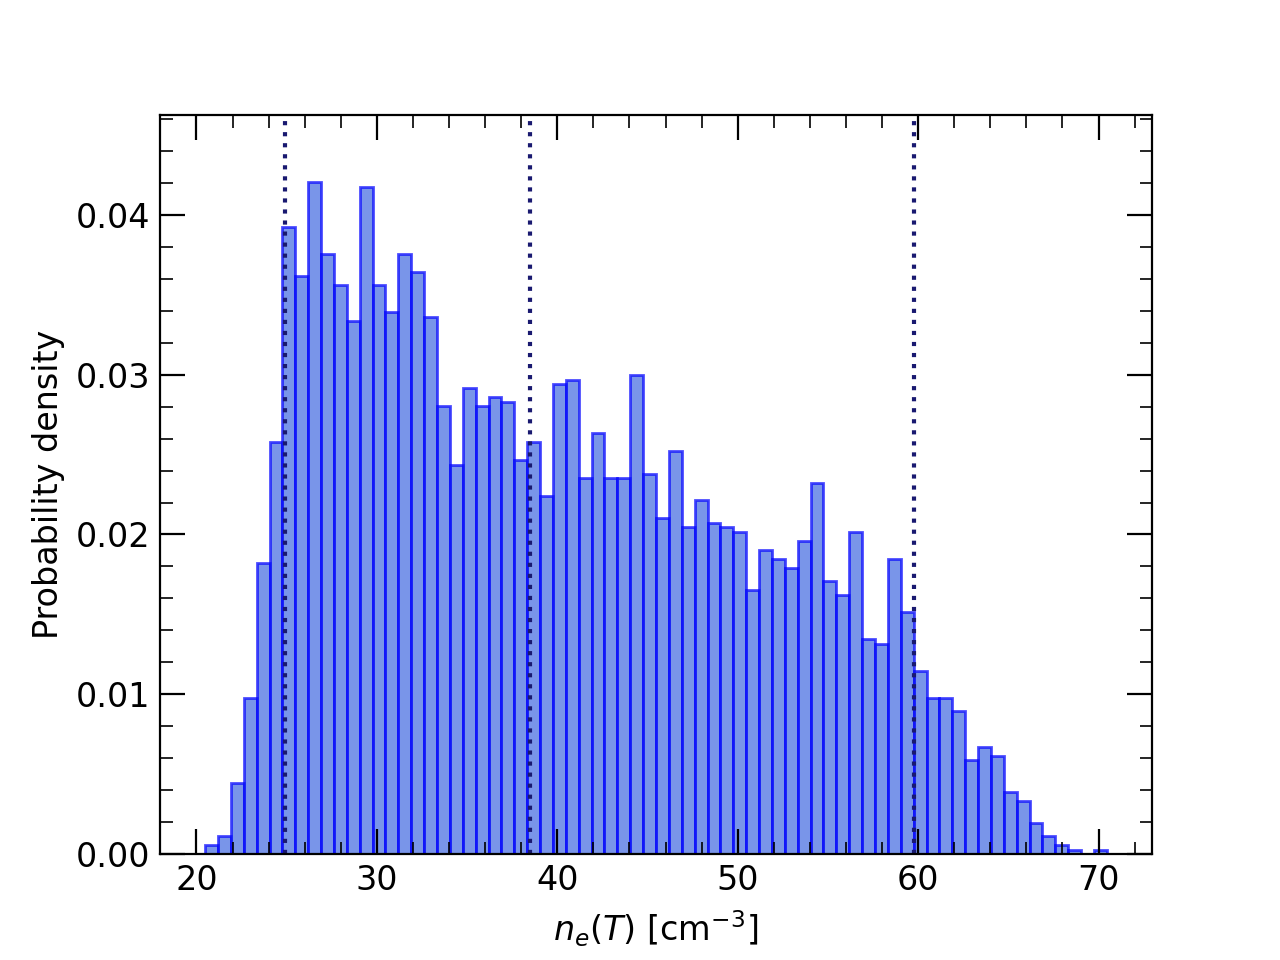

In [23]:
median = np.percentile(elec_density,50)
low_lim = np.percentile(elec_density,5)
high_lim = np.percentile(elec_density,95)
print('Median =',median,'Lower limit = ',low_lim,'Upper limit = ',high_lim)
histplot = plt.hist(elec_density,bins=70,color='royalblue',edgecolor='blue',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel(r'$n_e(T)$ [cm$^{-3}$]', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

### 2) Shock velocity

In [38]:
v_range = ( (16*T_axis*kb)/(3*mh) )**(1/2)/1e5
v_range_cm = ( (16*T_axis*kb)/(3*mh) )**(1/2)

<IPython.core.display.Javascript object>


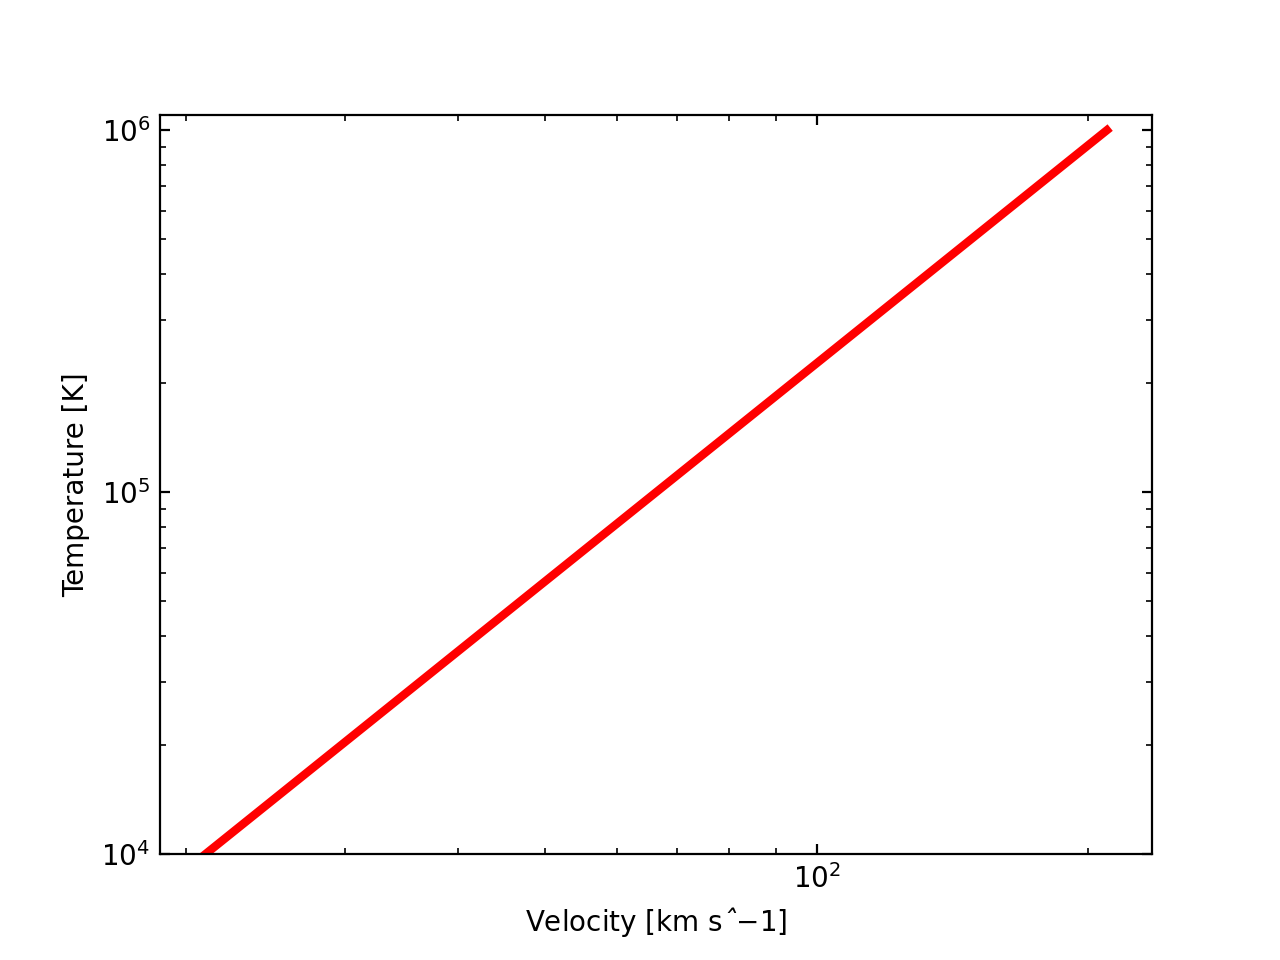

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.get_yaxis().set_tick_params(direction='in', which='both')
ax.get_xaxis().set_tick_params(direction='in', which='both')

ax.plot(v_range, T_axis, 'r-', lw=3)

ax.set_ylim(1e4, 1.1e6)
#ax.set_ylim(3., 5e2)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Velocity [km s$ˆ{-1}$]')
ax.set_ylabel(r'Temperature [K]')

plt.show()

### 3) Jet age

In [40]:
def age(disamin,d,incl,v):
    disasec = disamin*60 #lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
    discmP = dispc*pc #lobe target sepeartion in cm (projected)
    discm = discmP/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle
    t = 3/5*(discm/v) #time in seconds
    t_age_Myr = t/(365.*24.*60*60)/1.0E+6 #age of shock in Myr
    return t_age_Myr
    

In [41]:
# Generating distribution arrays for measurements
len_min = np.random.normal(disamin,disamin_err, n_iter) #distance between bowshock and target in arcmin
i_angle = np.random.normal(incl,incl_err,n_iter)  #inclination angle
#Obtaining distribution of age for different input parameters
t_age = Parallel(n_jobs=n_cores,verbose=5)(delayed(age)(len_min[i],dist[i],i_angle[i],v_range_cm[i]) for i in range(n_iter))


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.2s finished


Median = 0.43355078932576124 Lower limit =  0.15378808654464085 Upper limit =  1.2171245579220982


<IPython.core.display.Javascript object>


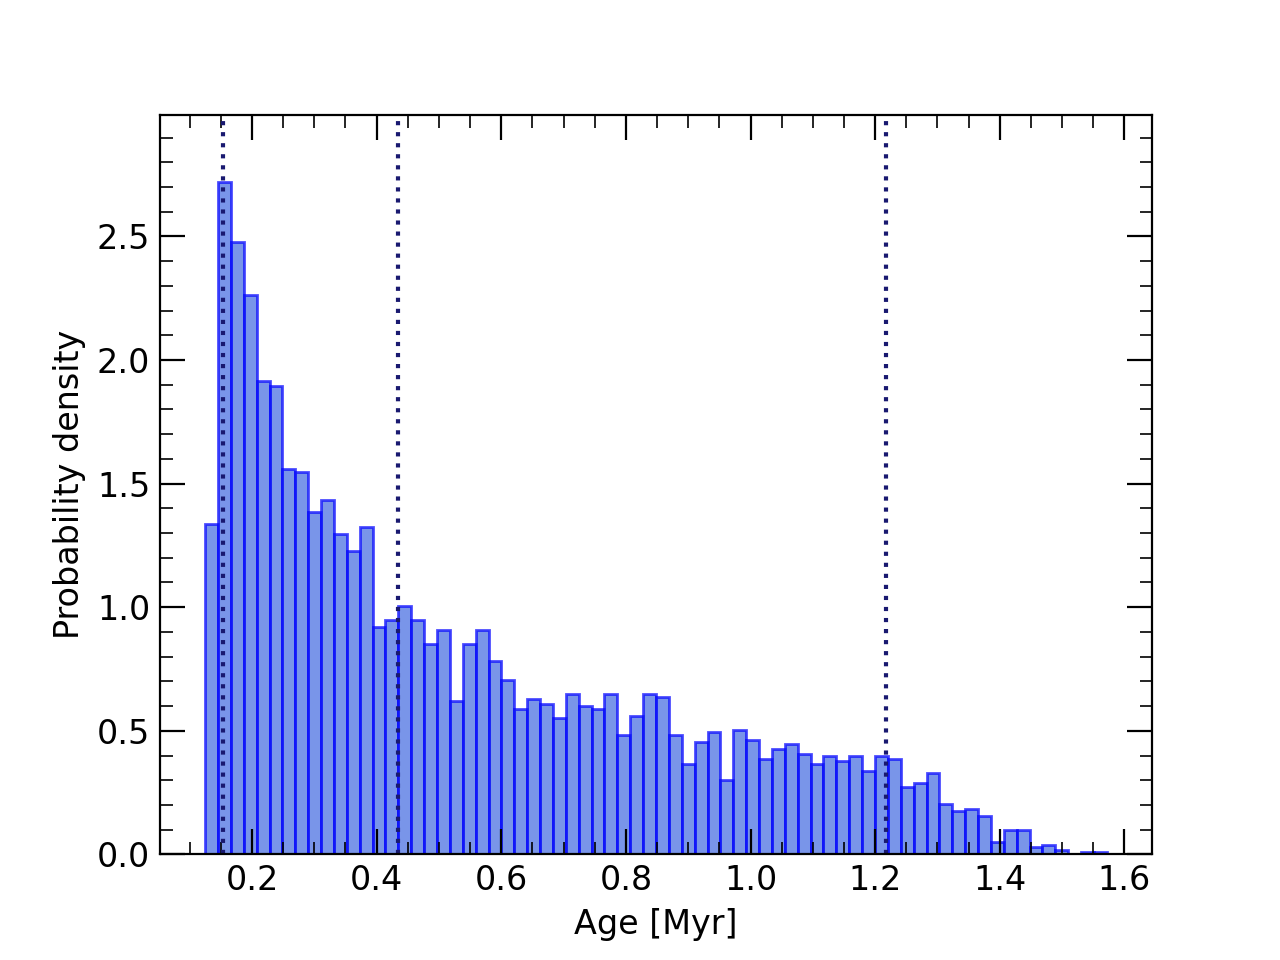

In [42]:
median = np.percentile(t_age,50)
low_lim = np.percentile(t_age,5)
high_lim = np.percentile(t_age,95)
print('Median =',median,'Lower limit = ',low_lim,'Upper limit = ',high_lim)
histplot = plt.hist(t_age,bins=70,color='royalblue',edgecolor='blue',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Age [Myr]', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

### Jet power

In [56]:
def power(theta,nee,disamin,vcm):
    theta_rad = theta*math.pi/180           # Jet opening angle, in radiants
    C2 = (((Gammac-1)*(Gammaj-1))/(4*Gammac) + 1 )**(Gammac/(Gammac-1)) * ((Gammaj+1)/(Gammaj-1))
    Rax = math.sqrt((1/4*(C2/theta_rad**2))) # axial ratio of the jet-blown cavity                         
    C3 = math.pi/(4*Rax**2)
    C1 = ((C2)/(C3*theta_rad**2)*((Gammax+1)*(Gammac-1)*(5-beta)**3)/(18*(9*(Gammac + (Gammac -1)*(C2/(4*theta_rad**2))) - 4 - beta)) )**(1/(5-beta))
    #nt=ne/x #where x is the ionisation fraction and is 1, use ne and nt interchangeably in the next equation
    rho = nee*1.370*mh;                    # Density of the gas down-stream of the shock, in cm-3 (calculated above with the calorimetry method above)
    rho0 = rho/4;                         # Density of the gas, up-stream of the shock, in cm-3
    disasec = disamin*60 #lobe target seperation in arcsec (projected)
    dispc = disasec*d*1e3*4.8*1e-6  #lobe target separation in pc (projected)
    discmP = dispc*pc #lobe target sepeartion in cm (projected)
    discm = discmP/math.sin(incl*math.pi/180) #lobe target de-projected seperation to account for the inclination angle
    Pjet = (5/3)**3 * rho0/C1*discm**2*vcm**3   # Upper limit to time averaged jet power 
    return Pjet

In [44]:
# Generating distribution arrays for measurements
open_angle = np.random.normal(o_a,o_a_err, n_iter) #opening angle
#Obtaining distribution of age for different input parameters
power_j = Parallel(n_jobs=n_cores,verbose=5)(delayed(power)(open_angle[i],elec_density[i],len_min[i],v_range_cm[i]) for i in range(n_iter))


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.2s finished


Median = 4.758782024002063e+38 ; Lower limit =  1.3938858669600704e+37 ; Upper limit =  1.6453734504941873e+40


<IPython.core.display.Javascript object>


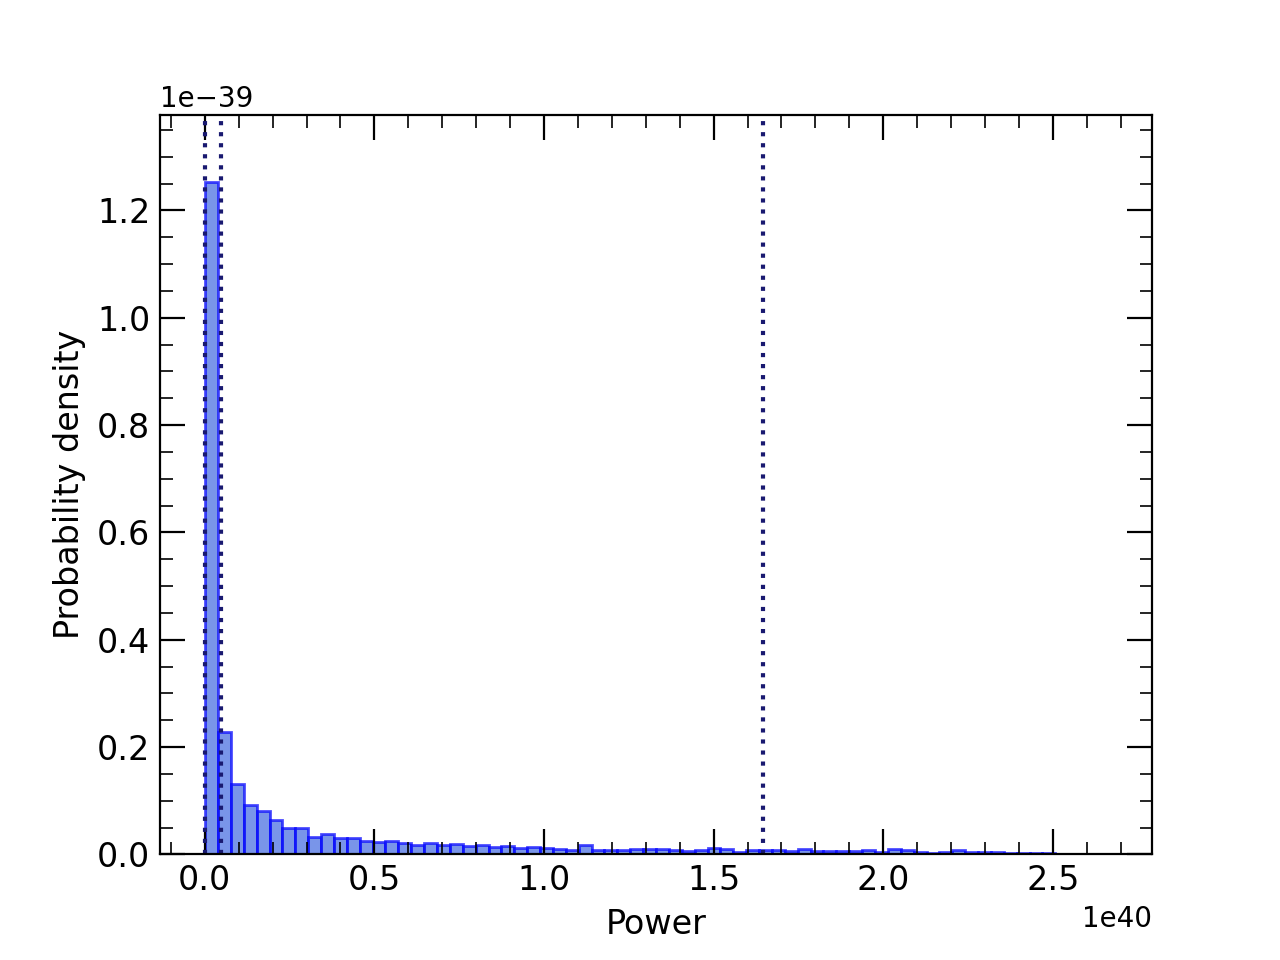

In [45]:
median = np.percentile(power_j,50)
low_lim = np.percentile(power_j,5)
high_lim = np.percentile(power_j,95)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)
histplot = plt.hist(power_j,bins=70,color='royalblue',edgecolor='blue',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Power', fontsize=12)
#plt.xlim(0,400)
#plt.title(str(name))
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

In [46]:
open_a = np.random.uniform(1,20, n_iter) #opening angle
g_c = np.random.uniform(4/3,5/3, n_iter) #opening angle
g_j = np.random.uniform(4/3,5/3, n_iter) #opening angle

In [47]:
# C12 constant calculation
def C_cons(g_c,g_j,g_x,ope):
    theta_ra = ope*math.pi/180           # Jet opening angle, in radiants
    C2_0 = (((g_c-1)*(g_j-1))/(4*g_c) + 1 )**(g_c/(g_c-1)) * ((g_j+1)/(g_j-1))
    Rax_0 = math.sqrt((1/4*(C2/theta_ra**2))) # axial ratio of the jet-blown cavity                         
    C3_0 = math.pi/(4*Rax_0**2)
    C1_0 = ((C2_0)/(C3_0*theta_ra**2)*((g_x+1)*(g_c-1)*(5-beta)**3)/(18*(9*(g_c + (g_c -1)*(C2/(4*theta_ra**2))) - 4 - beta)) )**(1/(5-beta))
    return C1_0

In [48]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)(g_c[i],g_j[i],(5.0/3),open_a[i]) for i in range(n_iter))


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.2s finished


Median = 3.8414754018051527 ; Lower limit =  2.7514352505617703 ; Upper limit =  8.949130597527134


<IPython.core.display.Javascript object>


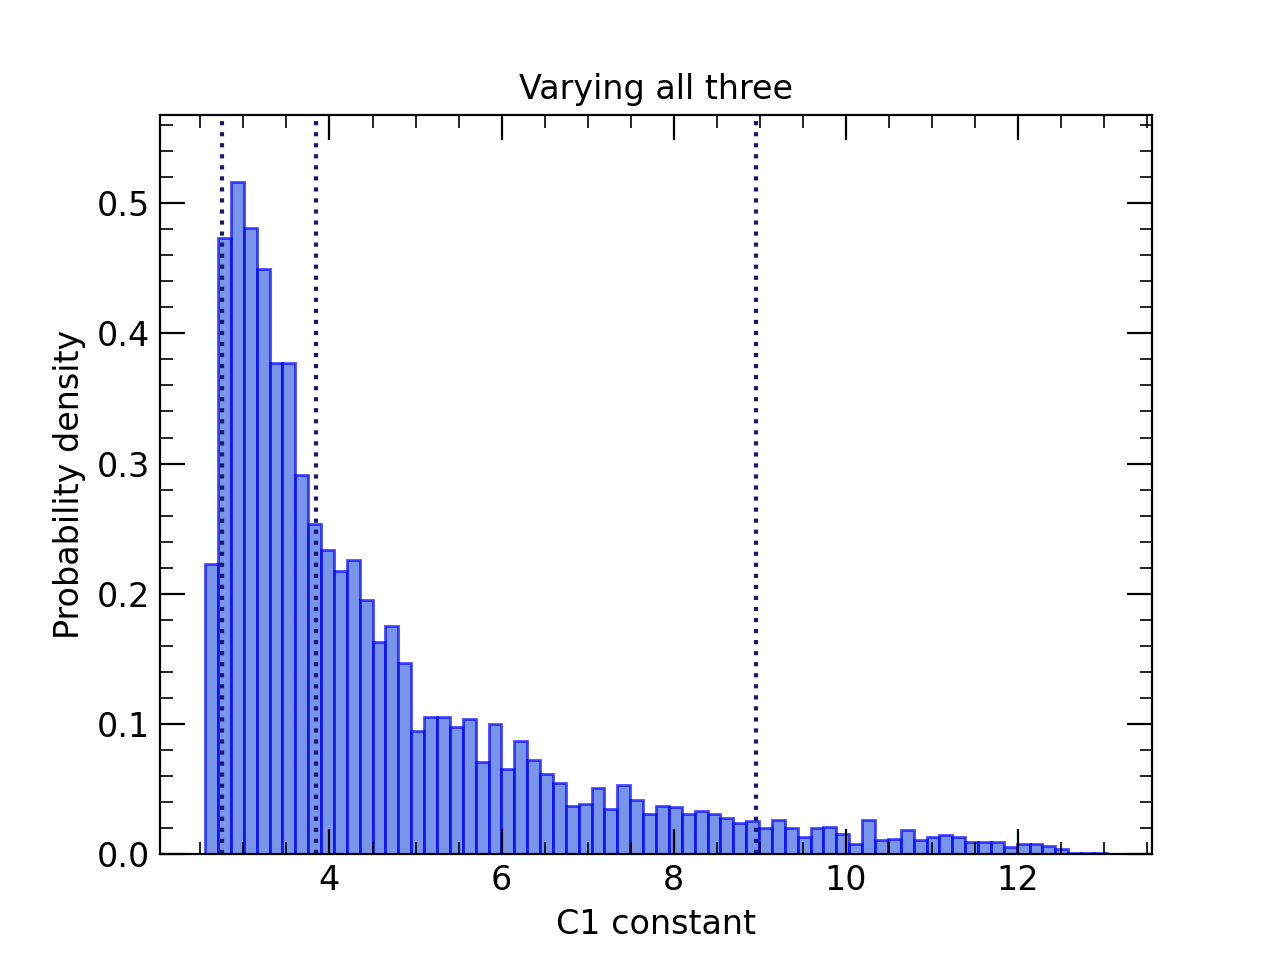

In [49]:
median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,5)
high_lim = np.percentile(ce_1,95)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)
histplot = plt.hist(ce_1,bins=70,color='royalblue',edgecolor='blue',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Varying all three')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s


Median = 3.6437490114278974 ; Lower limit =  2.624543704283486 ; Upper limit =  8.555560066235296


[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.2s finished


<IPython.core.display.Javascript object>


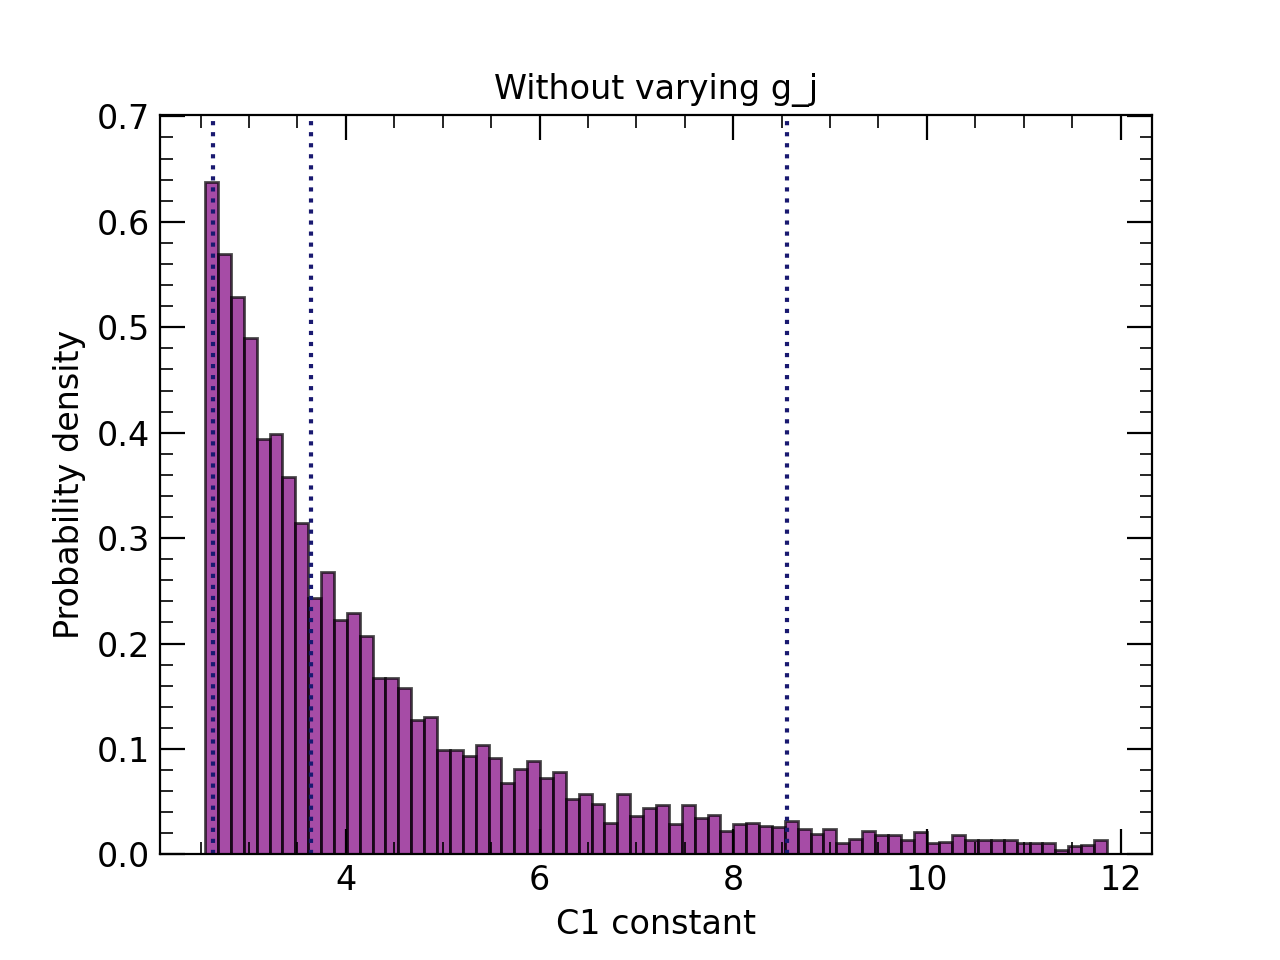

In [53]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)(g_c[i],(5.0/3),(5.0/3),open_a[i]) for i in range(n_iter))
median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,5)
high_lim = np.percentile(ce_1,95)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)
histplot = plt.hist(ce_1,bins=70,color='Purple',edgecolor='black',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Without varying g_j')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 4224 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 4969 out of 5000 | elapsed:    0.2s remaining:    0.0s


Median = 3.8506773085741375 ; Lower limit =  2.7641247041754893 ; Upper limit =  8.949023626172467


[Parallel(n_jobs=16)]: Done 5000 out of 5000 | elapsed:    0.2s finished


<IPython.core.display.Javascript object>


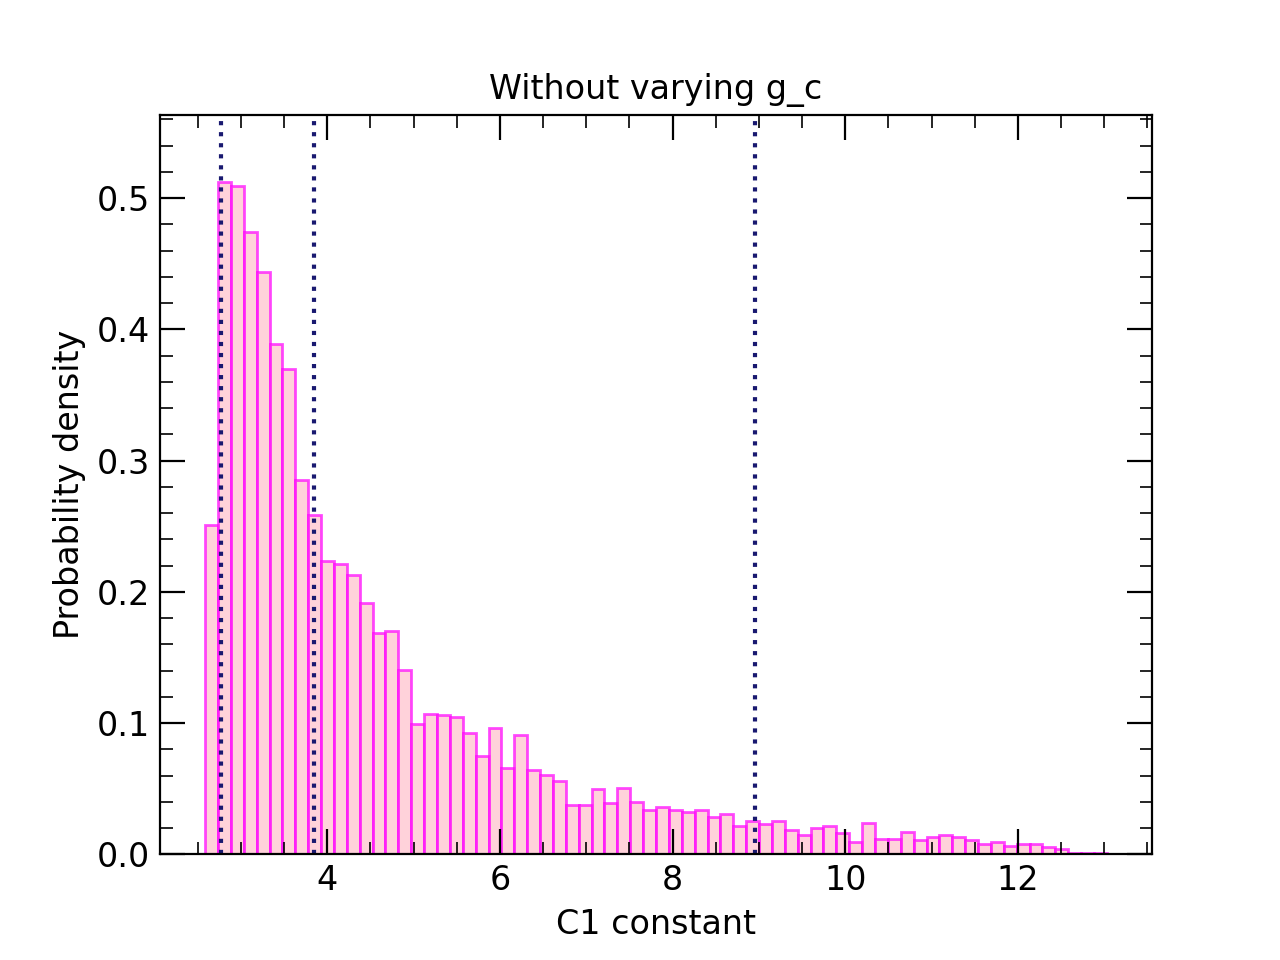

In [54]:
ce_1 = Parallel(n_jobs=n_cores,verbose=5)(delayed(C_cons)((5.0/3),g_j[i],(5.0/3),open_a[i]) for i in range(n_iter))
median = np.percentile(ce_1,50)
low_lim = np.percentile(ce_1,5)
high_lim = np.percentile(ce_1,95)
print('Median =',median,'; Lower limit = ',low_lim,'; Upper limit = ',high_lim)
histplot = plt.hist(ce_1,bins=70,color='pink',edgecolor='magenta',density=True,alpha=0.7)
plt.vlines([low_lim,high_lim],0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.vlines(median,0,max(histplot[0])*1.1,linestyles=':',colors='midnightblue')
plt.ylim(0,max(histplot[0])*1.1)
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('C1 constant', fontsize=12)
#plt.xlim(0,400)
plt.title('Without varying g_c')
plt.minorticks_on()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='major', length=9)
plt.tick_params(axis='both', which='minor', length=4.5)
plt.tick_params(axis='both', which='both',direction='in',right=True,top=True)
#plt.savefig(str(name)+'_peculiar_velocity.png')
plt.show()